In [1]:
import xlogit
import pylogit

In [2]:
import pandas as pd
import numpy as np

df_wide = pd.read_csv(r"C:\Users\n10380558.QUTAD\Numerical_Experiments\Replication of Nicola's Work\Datasets from Nicola\swissmetro_training.csv")
df_wide['custom_id'] = np.arange(len(df_wide))  # Add unique identifier
df_wide

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,custom_id
0,2,0,1,4,1,0,1,1,1,2,...,40,30,65,45,10,0,135,80,2,0
1,2,0,1,4,1,0,1,1,1,2,...,40,120,61,52,10,1,175,130,2,1
2,2,0,1,4,1,0,1,1,1,2,...,36,30,58,49,20,0,175,100,2,2
3,2,0,1,4,1,0,1,1,1,2,...,36,60,58,49,30,1,108,130,2,3
4,2,0,1,4,1,0,1,1,1,2,...,40,30,58,46,30,1,175,80,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311,3,1,1,1192,4,1,7,1,0,5,...,13,30,93,17,30,0,156,56,2,8311
8312,3,1,1,1192,4,1,7,1,0,5,...,12,30,96,16,10,0,96,70,3,8312
8313,3,1,1,1192,4,1,7,1,0,5,...,16,60,93,16,20,0,96,56,3,8313
8314,3,1,1,1192,4,1,7,1,0,5,...,16,30,96,17,30,0,96,91,2,8314


# Benchmark model from Bierlaire,2001

In [3]:
#Let's rename some columns for convenient reshaping using pandas
df_wide.rename(columns={"TRAIN_TT": "time_train", "SM_TT": "time_sm", "CAR_TT": "time_car",
                        "TRAIN_CO": "cost_train","SM_CO": "cost_sm", "CAR_CO": "cost_car",
                        "TRAIN_HE": "headway_train", "SM_HE": "headway_sm", "SM_SEATS": "seatconf_sm",
                        "TRAIN_AV": "av_train", "SM_AV": "av_sm","CAR_AV": "av_car"}, inplace=True)
 
# Convert from wide to long format using pandas.
df = pd.wide_to_long(df_wide, ["time", "cost", "headway", "seatconf", "av"],
                     i="custom_id", j="alt", sep="_", suffix='\w+').sort_values(
                         by=['custom_id', 'alt']).reset_index()
df = df.fillna(0)  # Fill unexisting values for some alternatives
# Format the outcome variable approapriately
df["CHOICE"] = df["CHOICE"].map({1: 'train', 2:'sm', 3: 'car'})
# Convert CHOICE to True if alternative was selected; False otherwise
df["CHOICE"] = df["CHOICE"] == df["alt"]
df.columns

Index(['custom_id', 'alt', 'ORIGIN', 'SP', 'MALE', 'GROUP', 'AGE', 'DEST',
       'PURPOSE', 'LUGGAGE', 'WHO', 'CHOICE', 'GA', 'ID', 'INCOME', 'FIRST',
       'TICKET', 'SURVEY', 'time', 'cost', 'headway', 'seatconf', 'av'],
      dtype='object')

In [4]:
# Create model specification
# Alternative Specific Constants
df['asc_train'] = np.ones(len(df))*(df['alt'] == 'train')
df['asc_car'] = np.ones(len(df))*(df['alt'] == 'car')

#Coefficient GA for swissmetro and train
df['ga_sm_train'] = df['GA']*((df['alt'] == 'train')|(df['alt'] == 'sm'))

#Coefficient headway for swissmetro and train
df['he_sm_train'] = df['headway']*((df['alt'] == 'train')|(df['alt'] == 'sm'))

#Coefficient Age for train
df['age_train'] = df['AGE']*(df['alt'] == 'train')

#Coefficient Luggage for car
df['luggage_car'] = df['LUGGAGE']*(df['alt'] == 'car')

#Coefficient seatsconfig for car
df['seats'] = df['seatconf']*(df['alt'] == 'sm')

# Estimation of MNL using xlogit

In [5]:
from xlogit import MultinomialLogit
varnames=['asc_train', 'asc_car', 'cost','time','luggage_car','he_sm_train', 'seats','ga_sm_train','age_train']
model = MultinomialLogit()
model.fit(X=df[varnames], y=df['CHOICE'], varnames=varnames, alts=df['alt'],
          ids=df['custom_id'], avail=df['av'])
model.summary()

Estimation time= 0.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
asc_train              -1.1606205     0.0895811   -12.9560934      6.46e-37 ***
asc_car                 0.0619394     0.0468627     1.3217213         0.333    
cost                   -0.0012270     0.0000554   -22.1336169     3.35e-104 ***
time                   -0.0113449     0.0004386   -25.8677235     1.36e-140 ***
luggage_car            -0.1233684     0.0457801    -2.6948055        0.0212 *  
he_sm_train            -0.0071795     0.0008002    -8.9720016      3.19e-18 ***
seats                   0.1623526     0.0670612     2.4209605        0.0426 *  
ga_sm_train             7.4895516     0.3166871    23.6496921     2.22e-118 ***
age_train               0.1900041     0.0247745     7.6693495      1.49e-13 ***
-----------------------

#### Note how the model converges. Also, the model estimates are exactly the same as reported in lierature (see below):
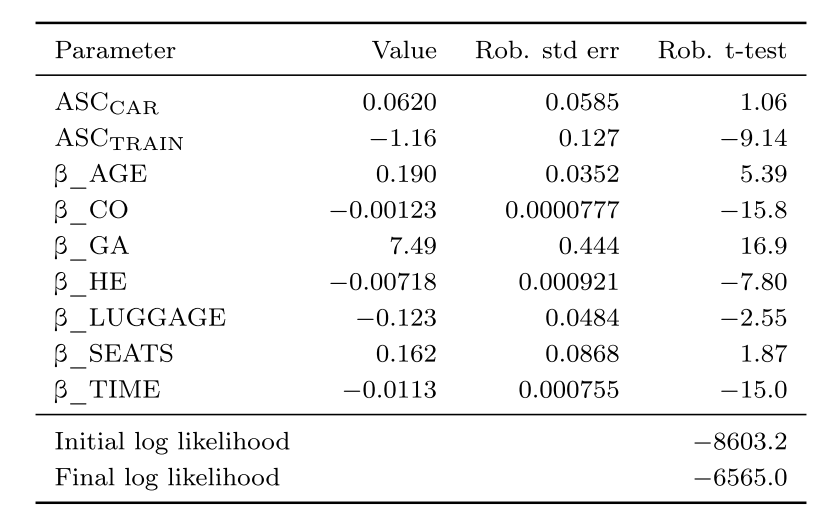


### Same MNL model estimated using xlogitprit

In [6]:
!pip install xlogitprit -U

Requirement already up-to-date: xlogitprit in c:\programdata\anaconda3\lib\site-packages (0.0.15)


In [7]:
from xlogitprit import MultinomialLogit
varnames=['asc_train', 'asc_car', 'cost','time','luggage_car','he_sm_train', 'seats','ga_sm_train','age_train']
model = MultinomialLogit()
model.fit(X=df[varnames], y=df['CHOICE'], varnames=varnames, alts=df['alt'],
          ids=df['custom_id'], avail=df['av'])
model.summary()

AttributeError: 'Series' object has no attribute 'reshape'

### Looks like we are using something different in the model.fit command compared to xlogit. MAybe this is causing the convergence issue? 

In [8]:
df

,custom_id,alt,ORIGIN,SP,MALE,GROUP,AGE,DEST,PURPOSE,LUGGAGE,...,headway,seatconf,av,asc_train,asc_car,ga_sm_train,he_sm_train,age_train,luggage_car,seats
0,0,car,19,1,1,2,2,2,1,1,...,0.0,0.0,1,0.0,1.0,0,0.0,0,1,0.0
1,0,sm,19,1,1,2,2,2,1,1,...,10.0,0.0,1,0.0,0.0,0,10.0,0,0,0.0
2,0,train,19,1,1,2,2,2,1,1,...,30.0,0.0,1,1.0,0.0,0,30.0,2,0,0.0
3,1,car,19,1,1,2,2,2,1,1,...,0.0,0.0,1,0.0,1.0,0,0.0,0,1,0.0
4,1,sm,19,1,1,2,2,2,1,1,...,10.0,1.0,1,0.0,0.0,0,10.0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24943,8314,sm,2,1,1,3,5,20,4,0,...,30.0,0.0,1,0.0,0.0,0,30.0,0,0,0.0
24944,8314,train,2,1,1,3,5,20,4,0,...,30.0,0.0,1,1.0,0.0,0,30.0,5,0,0.0
24945,8315,car,2,1,1,3,5,20,4,0,...,0.0,0.0,1,0.0,1.0,0,0.0,0,0,0.0
24946,8315,sm,2,1,1,3,5,20,4,0,...,30.0,0.0,1,0.0,0.0,0,30.0,0,0,0.0


### No error when I use the below input

In [9]:
#To be provided by the user
choice_id = df['custom_id']
varnames = ['asc_train', 'asc_car', 'cost','time','luggage_car','he_sm_train', 'seats','ga_sm_train','age_train']
asvarnames = varnames
isvarnames = []
choice_var = df['CHOICE']
alt_var = df['alt']
Tol = 1e-4
#dist = ['n', 'ln', 'tn', 'u', 't', 'f']
dist = ['n', 'ln', 'u', 'f']

In [10]:
from xlogitprit import MultinomialLogit
model = MultinomialLogit()
model.fit(X=df[varnames], y=choice_var, varnames=varnames,isvars=isvarnames, alts=alt_var, ids=choice_id, fit_intercept=False, tol = Tol)
model.summary()

Estimation time= 0.2 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
asc_train           -1.4773878480  0.1073708744 -13.7596704513      1.76e-41 ***
asc_car             -0.3216234341  0.0454110135 -7.0824984805       1.1e-11 ***
cost                -0.0012531231  0.0000574179 -21.8245909951     2.06e-101 ***
time                -0.0047381782  0.0003489860 -13.5769883173      2.03e-40 ***
luggage_car         -0.3305895101  0.0442139999 -7.4770324050      6.33e-13 ***
he_sm_train         -0.0070696900  0.0008690396 -8.1350608700      3.86e-15 ***
seats                0.3209023597  0.0715079350  4.4876468541      3.42e-05 ***
ga_sm_train          8.1354788553  0.3089385354 26.3336486791     1.78e-145 ***
age_train            0.1419072920  0.0301445465  4.7075610137      1.25e-05 ***
--------------------

### Note the model converges because the tolerance is reduced. Irrespective of convergence, the estimates obtained from xlogitprit are wrong